In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import os
import json
from copy import deepcopy as copy

In [2]:
import FRIB_model as frib

FRIB_model version: 1.0.0. updated on 2024-03-05


In [3]:
ISAAC_database_path = '/media/sf_HWANG/Workspace/BPM4pickup/ISAAC_data' 
ISAAC_data_rel_path = '20240118_103337_maruta_BDS_BTS_PM_D5567_pv_scan'

fm_evals, fm_goals, fm = frib.ISAAC_helper.get_flame_evals_n_goals_from_reconst_summary(
    ISAAC_data_rel_path = ISAAC_data_rel_path,
    ISAAC_database_path = ISAAC_database_path,
    return_flame = True)

In [4]:
fm_evals['df']

,BDS_BTS:QV_D5501,BDS_BTS:QH_D5509
,B2,B2
0,-10.64594,11.44014
1,-10.64594,14.56072
2,-10.64594,17.67845
3,-21.83254,11.77694
4,-17.67880,11.77694
5,-13.50977,11.77694
6,-9.35130,11.77694


In [5]:
fm_goals['df']

BDS_BTS:PM_D5567                  
              xrms     yrms      cxy
0          1.83538  1.39379  0.71569
1          0.63216  1.65509  0.07299
2          1.64770  1.99683 -0.48515
3              NaN  1.68100      NaN
4              NaN  1.26430  0.32410
5          2.27724  1.13207  0.59261
6          1.34012  1.59373  0.74214

# ISAAC reconstructed envelope 

In [6]:
r0,s0 = fm.run(monitor='all')
r0 = fm.collect_data(r0,'pos','xrms','yrms','cxy')

# New Fit at QV_D5501

In [7]:
to_element   = 'BDS_BTS:PM_D5567'
i_to_element   = fm.get_index_by_name(to_element  )[to_element  ][0]
from_bmstate = fm.bmstate

In [8]:
r1,s1 = fm.run(bmstate=from_bmstate, monitor='all',to_element=to_element)
r1 = fm.collect_data(r1,'pos','xrms','yrms','cxy')

##### before fit

In [9]:
bmstate = from_bmstate
xalpha, xbeta, _ = copy(bmstate.get_twiss('x'))
yalpha, ybeta, _ = copy(bmstate.get_twiss('y'))
xnemit = copy(bmstate.xnemittance)
ynemit = copy(bmstate.ynemittance)
cxy, cxyp, cxpy, cxpyp = copy([bmstate.couple_xy, bmstate.couple_xyp, bmstate.couple_xpy, bmstate.couple_xpyp])
print(xalpha, xbeta, xnemit)
print(yalpha, ybeta, ynemit)
print(cxy, cxyp, cxpy, cxpyp)

-0.13536536282448622 6.296390633400981 0.1544900120576113
0.6616155442220695 11.471087304551027 0.15983893165812568
0.7088686179632683 -0.6005281062250438 -0.34639533357318586 -0.5674139006963106


##### fitting

1-th trial, current_loss: 0.00162, best_loss: 0.00162


0.0016169634477428824

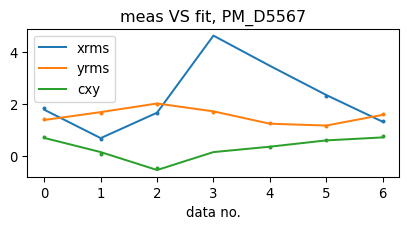

In [10]:
frib.flame_helper.fit_moment1(fm,fm_evals,fm_goals,
#                      from_bmstate = from_bmstate,
#                      from_element= i_from_element-1,
                     to_element  = i_to_element,
                     n_try = 20,
                     stop_criteria = 0.002,
                     start_fit_from_current_bmstate = True,
                     plot_fitting_quality = True,
                    )

##### after fit

In [11]:
bmstate = from_bmstate
xalpha, xbeta, _ = copy(bmstate.get_twiss('x'))
yalpha, ybeta, _ = copy(bmstate.get_twiss('y'))
xnemit = copy(bmstate.xnemittance)
ynemit = copy(bmstate.ynemittance)
cxy, cxyp, cxpy, cxpyp = copy([bmstate.couple_xy, bmstate.couple_xyp, bmstate.couple_xpy, bmstate.couple_xpyp])
print(xalpha, xbeta, xnemit)
print(yalpha, ybeta, ynemit)
print(cxy, cxyp, cxpy, cxpyp)

-0.17906785986082646 6.411559008565774 0.15108230685022403
0.6625724821922666 11.362174601026238 0.15996047967100901
0.8021423838615453 -0.5973920426501452 -0.8906067177534549 -0.9999999996430016


In [12]:
r2,s2 = fm.run(bmstate=from_bmstate, monitor='all',to_element=to_element)
r2 = fm.collect_data(r2,'pos','xrms','yrms','cxy')

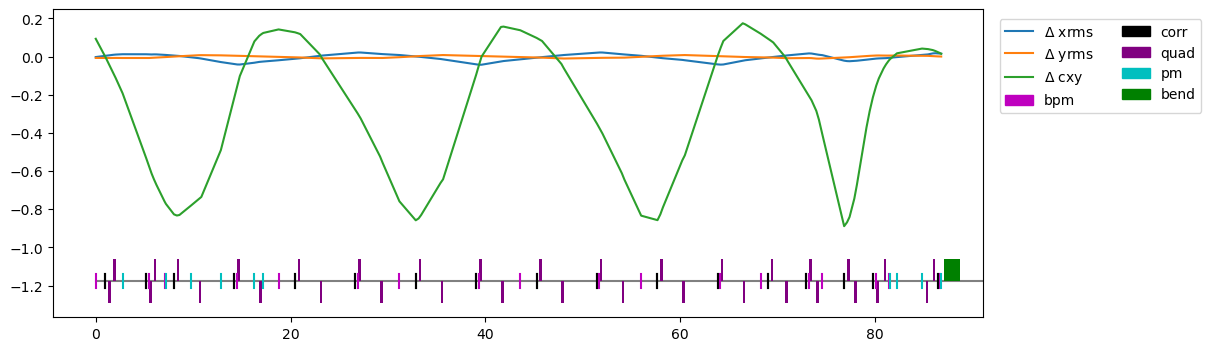

In [13]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(r2['pos'],r2['xrms']-r1['xrms'],label=r'$\Delta$ xrms')
ax.plot(r2['pos'],r2['yrms']-r1['yrms'],label=r'$\Delta$ yrms')
ax.plot(r2['pos'],r2['cxy' ]-r1['cxy' ],label=r'$\Delta$ cxy')
frib.flame_helper.plot_lattice(fm,ax)

# flame_results

In [14]:
frib.flame_helper.calculate_loss_from_flame_evals_goals(fm_evals,fm_goals,fm,from_bmstate,
                                               from_element=None,
                                               to_element=to_element,
                                               )

0.0016169634477428824

In [15]:
flame_results = frib.flame_helper.evaluate_flame_evals(
    fm_evals,fm,from_bmstate,
    from_element=None,
    to_element=to_element,
    monitor_names = list(fm_goals['info'].keys()),
    )

In [16]:
flame_results

BDS_BTS:PM_D5567                    
              xrms      yrms       cxy
0         1.765104  1.371116  0.678980
1         0.671668  1.674226  0.134252
2         1.652187  2.006610 -0.556632
3         4.622027  1.703204  0.133683
4         3.460450  1.228064  0.341491
5         2.334866  1.156618  0.584359
6         1.306083  1.566740  0.699710

Text(0.5, 0, 'data no.')

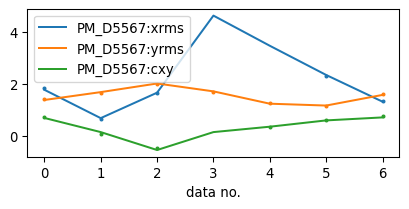

In [17]:
flame_goals = fm_goals

monitors = list(flame_goals['info'].keys())
for i,m in enumerate(monitors):
    fig,ax = plt.subplots(figsize=(5,2), dpi=96)
    for k in flame_results[m].columns:
        col = (m,k)
        if not np.all(np.isnan(flame_goals['df'][col])):
            x = np.arange(len(flame_results))
            ax.scatter(x,flame_goals['df'][col],s=4)
            ax.plot   (x,flame_results[col],label=m[m.find(":")+1:]+':'+k)
    ax.legend()
ax.set_xlabel('data no.')